# Navigation

---

In this notebook, we will use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [14]:
from unityagents import UnityEnvironment
import numpy as np
import time
from collections import deque
from dqn_agent import Agent
import matplotlib.pyplot as plt
import torch


In [2]:
env = UnityEnvironment(file_name="./Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 



In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

Use the Python API to control the agent and receive feedback from the environment.

The agent selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

In the next step the agent will be able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


### 4. Train the Agent with DQN


Now we will train our own agent to solve the environment!  When training the environment,we set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
# Deep Q-Learning function

def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, train_mode=True, 
        ckpt_path='pth_checkpoints/checkpoint.pth'):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        train_mode (bool): if 'True' set environment to training mode
        
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    moving_avgs = []                   # list of moving averages
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name] # reset environment
        state = env_info.vector_observations[0]                 # get current state        
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)                      # select an action
            env_info = env.step(action)[brain_name]             # send action to environment
            next_state = env_info.vector_observations[0]        # get next state
            reward = env_info.rewards[0]                        # get reward
            done = env_info.local_done[0]                       # see if episode has finished
            agent.step(state, action, reward, next_state, done) # learning step
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)          # save most recent score to window
        scores.append(score)                 # save most recent score to total
        moving_avg = np.mean(scores_window)  # calculate moving average
        moving_avgs.append(moving_avg)       # save most recent moving average
        eps = max(eps_end, eps_decay*eps)    # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, moving_avg), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, moving_avg))
        if moving_avg >= 13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, moving_avg))
            if train_mode:
                torch.save(agent.qnetwork_local.state_dict(), ckpt_path)
            break
    return scores, moving_avgs

In [22]:
# Train the agent using DQN

# run the training loop
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

start_time = time.time() # Monitor Training Time  
scores, avgs = dqn(n_episodes=1000, eps_decay=0.98, eps_end=0.02, ckpt_path='./pth_checkpoints/checkpoint.pth')
print("\nTotal Training time = {:.1f} min".format((time.time()-start_time)/60))

Episode 100	Average Score: 4.57
Episode 200	Average Score: 8.09
Episode 300	Average Score: 9.84
Episode 400	Average Score: 10.89
Episode 500	Average Score: 12.10
Episode 579	Average Score: 13.02
Environment solved in 479 episodes!	Average Score: 13.02

Total Training time = 6.4 min


### 5. Plot the scores

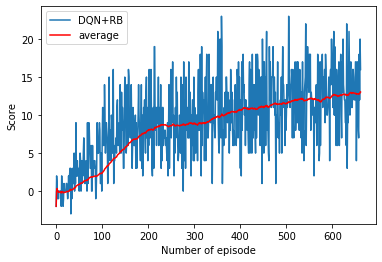

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='DQN+RB')
plt.plot(np.arange(len(scores)), avgs, c='r', label='average')
plt.ylabel('Score')
plt.xlabel('Number of episodes')
plt.legend(loc='upper left')
plt.show()

### 6. Test the saved agent

Episode 1	Average Score: 10.00
Episode 2	Average Score: 13.50
Episode 3	Average Score: 12.33
Episode 4	Average Score: 13.00
Episode 5	Average Score: 13.40
Episode 6	Average Score: 13.50
Episode 7	Average Score: 13.00
Episode 8	Average Score: 12.88
Episode 9	Average Score: 11.89
Episode 10	Average Score: 11.60


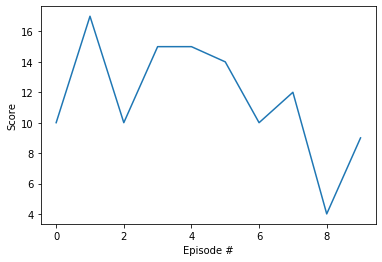

In [19]:
# initialize the agent
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

# load the weights from file
checkpoint = './pth_checkpoints/v28_checkpoint.pth'
agent.qnetwork_local.load_state_dict(torch.load(checkpoint))

num_episodes = 10
scores = []
for i_episode in range(1,num_episodes+1):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    while True:
        action = agent.act(state, eps=0)               # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        #agent.step(state, action, reward, next_state, done) # do the learning

        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            scores.append(score)
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores)))
            break

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Number of Episodes')
plt.show()

When finished, close the environment.

In [ ]:
env.close()